In [1]:

import netket as nk
import netket_dynamics as nkd

import matplotlib.pyplot as plt

100%|██████████| 150/150 [00:11<00:00, 13.04it/s, Energy=-40.362+0.022j ± 0.071 [σ²=5.135, R̂=0.9969]]


x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<S

  0%|          | 0/2.0 [00:00<?, ?it/s, generator=-20.325+0.011j ± 0.085 [σ²=7.309, R̂=1.0006]]

x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=0/1)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10,10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>
x=Traced<ShapedArray(complex128[10])>with<DynamicJaxprTrace(level=1/2)>  target=Traced<S

100%|██████████| 2.0024999999999684/2.0 [04:06<00:00, 123.19s/it, generator=-19.42-0.01j ± 0.13 [σ²=16.54, R̂=0.9998]]     
C:\Users\pimve\anaconda3\envs\pcqi\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


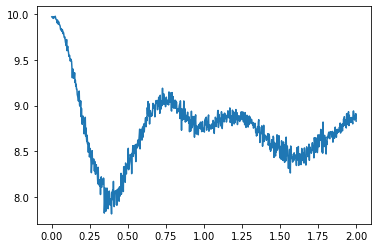

In [2]:
# 1D Lattice
L = 10

g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

# Hilbert space of spins on the graph
hi = nk.hilbert.Spin(s=1 / 2, N=g.n_nodes)

# Ising spin hamiltonian
ha = nk.operator.Ising(hilbert=hi, graph=g, h=4.0)

# RBM Spin Machine
ma = nk.models.RBM(alpha=1, use_visible_bias=True, dtype=complex)

# Metropolis Local Sampling
sa = nk.sampler.MetropolisHamiltonian(hi, ha, n_chains=16)

# Variational state
vs = nk.vqs.MCState(sa, ma, n_samples=1008, n_discard_per_chain=100, seed = 3)

# Optimizer
op = nk.optimizer.Sgd(0.01)
sr = nk.optimizer.SR(diag_shift=1e-4)

# Variational monte carlo driver
gs = nk.VMC(ha, op, variational_state=vs)

# Create observable
Sx = sum([nk.operator.spin.sigmax(hi, i) for i in range(L)])

# Run the optimization for 300 iterations
gs.run(n_iter=150, out="example_ising1d_GS", obs={"Sx": Sx})
W_0 = vs.parameters
ket_0 = vs.to_qobj()

# Create solver for time propagation
ha1 = nk.operator.Ising(hilbert=hi, graph=g, h=2)
vs.parameters = W_0
te = nkd.TimeEvolution(ha1, variational_state=vs, algorithm=nkd.Euler(), dt=0.0025)

log = nk.logging.JsonLog("example_ising1d_TE")
te.run(2.0, out=log, show_progress=True, obs={"SX": Sx})

plt.plot(log.data["t"], log.data["SX"])
plt.show()

C:\Users\pimve\anaconda3\envs\pcqi\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


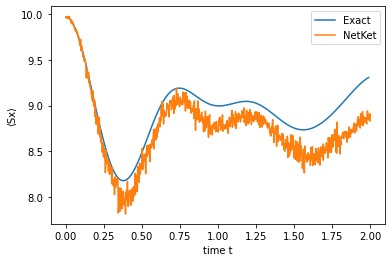

In [3]:
import qutip
import numpy as np

tvals = np.arange(0.0, 2.0, 0.01)
sol = qutip.sesolve(ha1.to_qobj(), ket_0, tvals, e_ops=[Sx.to_qobj()])

plt.plot(sol.times, sol.expect[0], label="Exact")
plt.plot(log.data["t"], log.data["SX"], label="NetKet")
plt.xlabel("time t")
plt.ylabel("⟨Sx⟩")
plt.legend()
plt.show()